# This is notebook mainly shows the methods about halos rendering 

Including:

### Initializing the Halos Pipeline
This section initializes the `HalosSkyPyPipeline` with specified parameters such as sky area and mass range. The pipeline is prepared for halo generation and mass sheet correction calculations. After initialization, the halos generated by the pipeline are displayed, and a scatter plot of redshift (`z`) versus the logarithm of the mass (`log10(mass)`) for the halos is plotted.

### Plotting the Convergence Map for the Halos
This section focuses on plotting the convergence map for the halos, both with and without mass sheet correction. The convergence map visualizes the impact of the mass distribution on light bending, an essential aspect of gravitational lensing studies.

### Render the Joint Contribution of External Convergence and Shears from Halos Rendering
Here, we render the joint contribution of external convergence and shears resulting from halos rendering. This analysis helps in understanding the combined effect of multiple halos on the gravitational lensing signal.

### Combine the Halos and Glass Data
This section combines the halos data with glass data. The glass data typically represents a random field that mimics the underlying mass distribution in the universe, and combining it with halos data provides a comprehensive view of the mass distribution.

### Plotting the Joint Distribution of Kappa and Gamma (specific redshifts)
Finally, this section plots the joint distribution of kappa and gamma, both with and without non-linear correction. Kappa represents the convergence, while gamma represents the shear. Analyzing their joint distribution helps in understanding the overall effect of lensing by the mass distribution, including both linear and non-linear contributions.

In [1]:
from slsim.Pipelines.halos_pipeline import HalosSkyPyPipeline
from slsim.Halos.halos_lens_base import HalosLensBase
import numpy as np
from astropy.cosmology import default_cosmology, FlatLambdaCDM
import matplotlib.pyplot as plt
from slsim.Halos.halos_plus_glass import (
    read_glass_data,
    skyarea_form_n,
    generate_samples_from_glass,
    halos_plus_glass,
    convergence_mean_0,
    run_certain_redshift_lensext_kde_by_multiprocessing,
)
import os
from slsim.Halos.halos_plus_glass import run_halos_without_kde_by_multiprocessing
import seaborn as sns
import pandas as pd

# Initializing the Halos Pipeline
Initializes the 'HalosSkyPyPipeline' with specified parameters like sky area and mass range, preparing the pipeline for halo generation and mass sheet correction calculations.
Shows the halos generated by the pipeline and plots a scatter plot of z vs. log10(mass) for the halos.

        z                 mass       
------------------ ------------------
1.9067265857484421 345950291375.77924
1.1287831385121603  312299540965.8671
2.7884112019062313 205287627332.68015
2.7853863627926527 244822970882.89456
3.2164853950517722  1184017005767.262
1.2111135535849031  209448177392.5787
 2.638269469619804  268742206152.5953
 1.117577512361679 548094579052.39703
 1.886859325427998 231210059518.07574
1.0453005471192645   43789708855061.4
               ...                ...
1.1765418610272051  621042529830.7664
1.9834203703302198 231582243604.69128
 2.027068703396009   301972296212.416
1.2981025376372628 2290975345541.8716
2.0185179942389087 265535983776.99094
 3.752657536838014 500468818839.38556
 4.477500521471139   321579462949.617
1.6245356708415077  614013150993.6431
 1.560604756733728  285573117639.2707
 3.138519334224035  956310505274.6344
Length = 73 rows


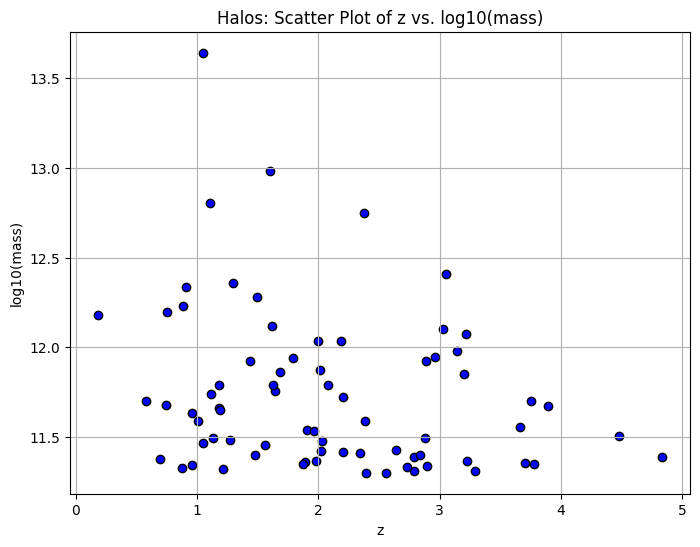

In [2]:
pipeline = HalosSkyPyPipeline(
    sky_area=0.00036,  # in square degrees
    m_max="1.0E+16",  # in solar masses
    m_min="2.0E+11",
    z_max=5.00,
)
halos = pipeline.halos
mass_sheet_correction = (
    pipeline.mass_sheet_correction
)  # calculating a negative convergence for
# mass sheet based on the average convergence of multiple halos rendering

print(halos)
z_halos = halos["z"]
mass_halos = halos["mass"]

log_mass = np.log10(mass_halos)
plt.figure(figsize=(8, 6))
plt.scatter(z_halos, log_mass, c="blue", marker="o", edgecolors="black")
plt.title("Halos: Scatter Plot of z vs. log10(mass)")
plt.xlabel("z")
plt.ylabel("log10(mass)")
plt.grid(True)

# Plotting the convergence map for the halos
## with or without mass sheet correction

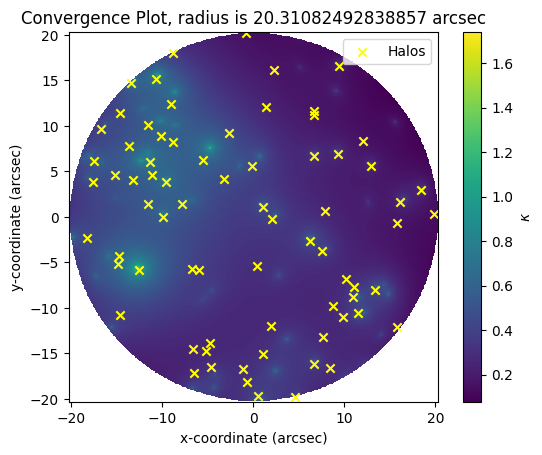

In [3]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLensBase(
    halos_list=halos,
    mass_correction_list=mass_sheet_correction,
    mass_sheet=True,
    sky_area=0.0001,
    cosmo=cosmo,
)
halos_lens.plot_halos_convergence(
    diff=0.01,
)

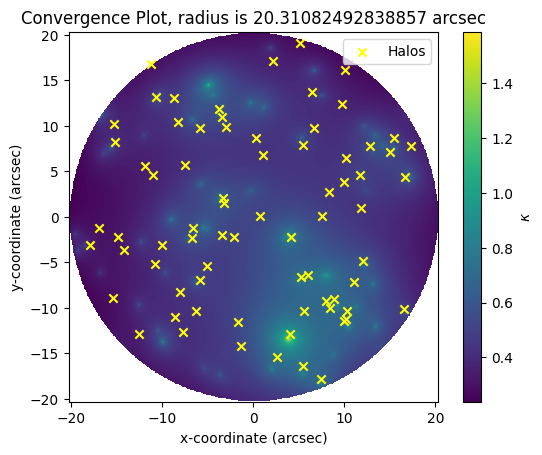

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# Instantiate the HalosLens class with the halo list computed above and a defined sky area
halos_lens = HalosLensBase(
    halos_list=halos,
    mass_correction_list=None,  # No mass sheet correction
    mass_sheet=False,  # No mass sheet correction
    sky_area=0.0001,
    cosmo=cosmo,
)
halos_lens.plot_halos_convergence(diff=0.01)

## Render the joint contribution of external convergence and shears from halos rendering

In [5]:
halos_k, halos_g = run_halos_without_kde_by_multiprocessing(
    n_iterations=100,
    sky_area=0.00036,
    samples_number=100,
    cosmo=cosmo,
    z_max=5.0,
)

kappa_random_halos = convergence_mean_0(halos_k)
gamma_random_halos = halos_g

The 100 halo-lists took 28.657554864883423 seconds to run


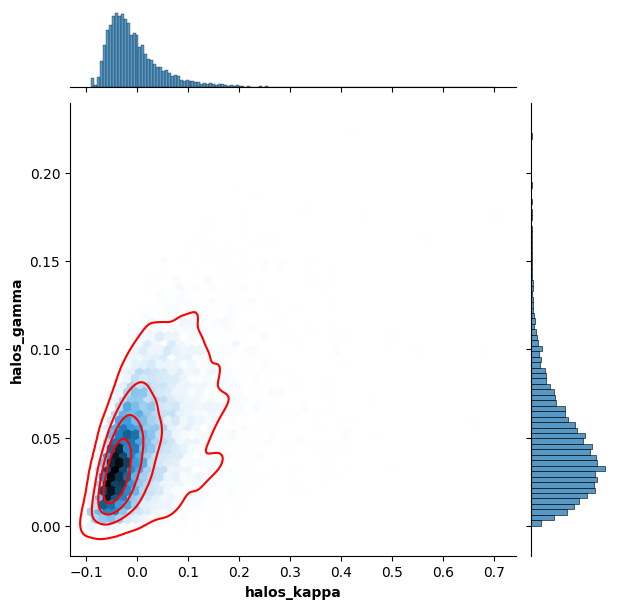

In [6]:
total_plot = sns.jointplot(x=kappa_random_halos, y=gamma_random_halos, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("halos_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("halos_gamma", fontweight="bold")
plt.show()

## Combine the halos and glass data

In [9]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
slsim_directory = os.path.dirname(parent_directory)
file_path = os.path.join(parent_directory, "../tests/TestData/kgdata.npy")

In [10]:
kappa_values, gamma_values, nside = read_glass_data(file_name=file_path)
skyarea = skyarea_form_n(nside)
kappa_random_glass, gamma_random_glass = generate_samples_from_glass(
    kappa_values, gamma_values, n=5000
)
print(kappa_random_glass.shape, gamma_random_glass.shape)

(5000,) (5000,)


In [11]:
total_kappa, total_gamma = halos_plus_glass(
    kappa_random_glass, gamma_random_glass, kappa_random_halos, gamma_random_halos
)

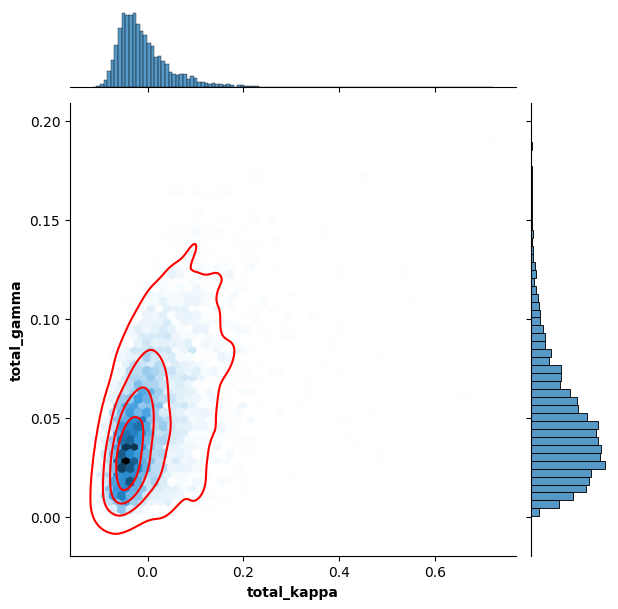

In [12]:
total_plot = sns.jointplot(x=total_kappa, y=total_gamma, kind="hex")
total_plot.plot_joint(sns.kdeplot, color="r", zorder=3, levels=5)
total_plot.ax_joint.set_xlabel("total_kappa", fontweight="bold")
total_plot.ax_joint.set_ylabel("total_gamma", fontweight="bold")
plt.show()

# Plotting the joint distribution of kappa and gamma
## with and without non-linear correction


In [13]:
def plot_kappa_gamma(
    zs=1.5,
    zd=0.5,
    n_iterations=300,
    sky_area=0.00036,
    samples_number=30,
    m_min="1.0E+12",
    m_max="1.0E+16",
):
    # Setup Cosmology
    cosmo = default_cosmology.get()
    # Without Correction
    nk, ng = run_halos_without_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        listmean=False,
    )
    nk_mean = sum(nk) / len(nk)
    print(f"zs={zs}, zd={zd},k_s_mean={nk_mean}")
    nk = convergence_mean_0(nk)

    # With Correction
    distribution = run_certain_redshift_lensext_kde_by_multiprocessing(
        n_iterations=n_iterations,
        sky_area=sky_area,
        samples_number=samples_number,
        cosmo=cosmo,
        m_min=m_min,
        m_max=m_max,
        z_max=zs,
        zs=zs,
        zd=zd,
        listmean=False,
    )
    nk1 = [point[0] for point in distribution]
    ng1 = [point[1] for point in distribution]
    nk1_mean = sum(nk1) / len(nk1)
    print(f"zs={zs}, zd={zd},k_ext_mean={nk1_mean}")
    nk1 = convergence_mean_0(nk1)

    # Combine Data for Joint KDE Plot
    df1 = pd.DataFrame({"x": nk, "y": ng, "type": "Without non-linear Correction"})
    df2 = pd.DataFrame({"x": nk1, "y": ng1, "type": "With non-linear Correction"})
    df_total = pd.concat([df1, df2], axis=0)

    var_nk = np.var(nk)
    var_nk1 = np.var(nk1)
    print(f"Variance of k_S: {var_nk}")
    print(f"Variance of k_ext: {var_nk1}")

    # Plotting
    plot = sns.jointplot(data=df_total, x="x", y="y", hue="type", kind="kde")

    plot.ax_joint.set_xlabel("kappa")
    plot.ax_joint.set_ylabel("gamma")
    m_min_float = float(m_min)
    plt.title(f"zs={zs}, zd={zd}, mean=0")
    plot.fig.suptitle(
        f"zs={zs}, zd={zd}, m=10^{np.log10(m_min_float)}, mean=0, with mass-sheet"
    )
    plot.ax_joint.set_xlim(-0.1, 0.2)
    plot.ax_joint.set_ylim(-0.01, 0.08)

    plt.show()


# To use the function:
# plot_kappa_gamma(zs=1.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
# plot_kappa_gamma(zs=2.5, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
# plot_kappa_gamma(zs=2.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
# plot_kappa_gamma(zs=1.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")

The 300 halo-lists took 108.82744097709656 seconds to run
zs=5.0, zd=0.5,k_s_mean=0.08760457229588788
The 300 halo-lists took 285.77021288871765 seconds to run
zs=5.0, zd=0.5,k_ext_mean=0.01852987195067273
Variance of k_S: 0.00569622780767794
Variance of k_ext: 0.003199850292553256


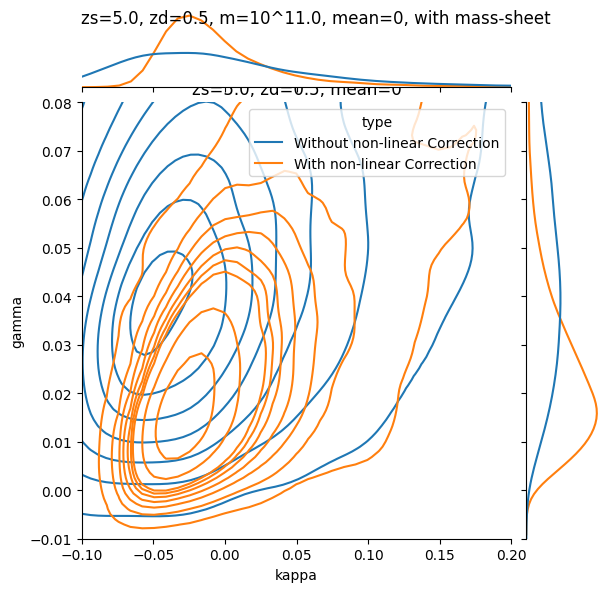

The 300 halo-lists took 107.83921098709106 seconds to run
zs=5.0, zd=1.5,k_s_mean=0.09169813308665681
The 300 halo-lists took 280.50653100013733 seconds to run
zs=5.0, zd=1.5,k_ext_mean=0.0464118627846506
Variance of k_S: 0.0058113593741188786
Variance of k_ext: 0.007315571962385071


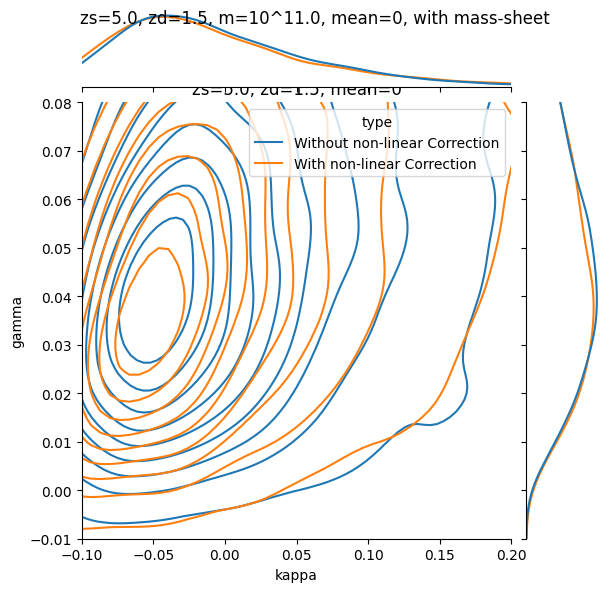

The 300 halo-lists took 104.88360714912415 seconds to run
zs=5.0, zd=2.5,k_s_mean=0.08427887989253297
The 300 halo-lists took 271.0216760635376 seconds to run
zs=5.0, zd=2.5,k_ext_mean=0.080685236492045
Variance of k_S: 0.005275084895452513
Variance of k_ext: 0.011697802735166307


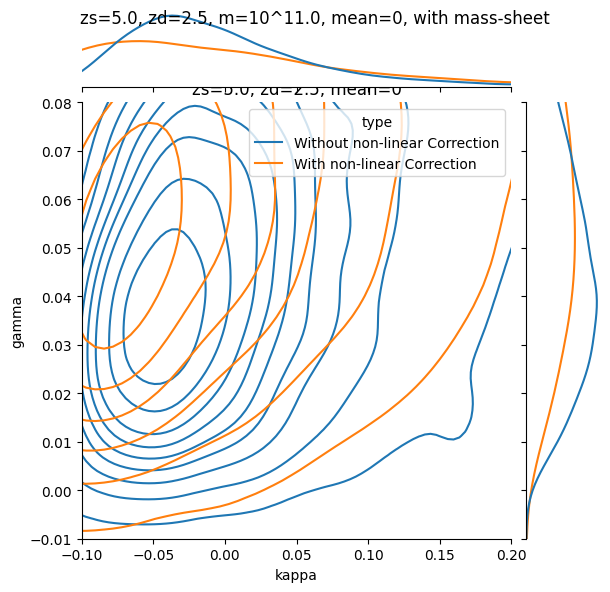

The 300 halo-lists took 111.96347713470459 seconds to run
zs=5.0, zd=3.5,k_s_mean=0.0850052033807634
The 300 halo-lists took 280.1898601055145 seconds to run
zs=5.0, zd=3.5,k_ext_mean=0.10116006015608278
Variance of k_S: 0.005689770044690586
Variance of k_ext: 0.012574285073638912


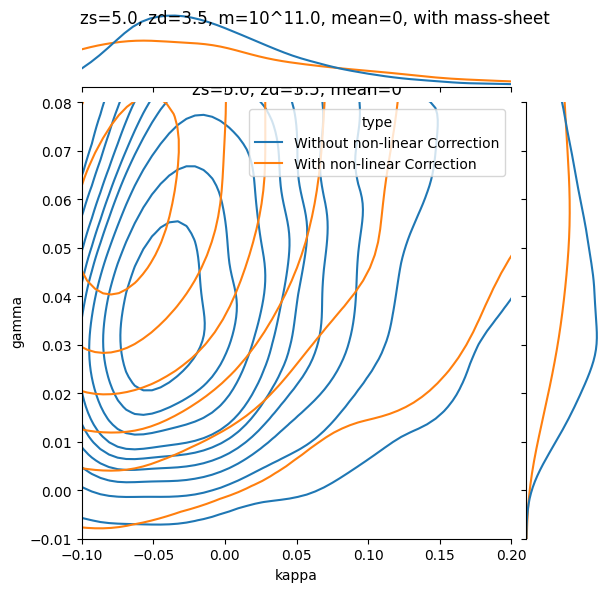

The 300 halo-lists took 116.43997168540955 seconds to run
zs=5.0, zd=4.5,k_s_mean=0.0884201303282582
The 300 halo-lists took 306.5845408439636 seconds to run
zs=5.0, zd=4.5,k_ext_mean=0.14236779170294062
Variance of k_S: 0.006769783606792559
Variance of k_ext: 0.014657681930254537


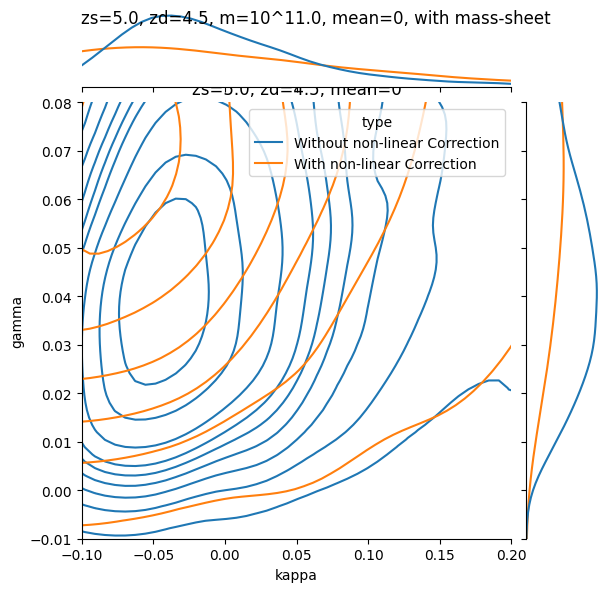

In [14]:
plot_kappa_gamma(zs=5.0, zd=0.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=5.0, zd=1.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=5.0, zd=2.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=5.0, zd=3.5, m_min="1.0E+11", m_max="1.0E+16")
plot_kappa_gamma(zs=5.0, zd=4.5, m_min="1.0E+11", m_max="1.0E+16")